In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import pyddm
import pyddm.plot
from scipy import stats

from drift_diffusion.sim import sim_ddm

%matplotlib inline

(a) Try the [PyDDM](https://github.com/mwshinn/PyDDM) package.

(b) Fit the simulated data from `sim_ddm` where you know ground truth about the true generative model. Do you recover the true parameters? 

Info: Params [ 0.93304078  1.49157584 -0.34385098  0.11602502] gave 8485.055836462929


{'IC': {'x0': Fitted(-0.34385098176964535, minval=-1, maxval=1)},
 'bound': {'B': Fitted(1.4915758426281598, minval=0.1, maxval=2)},
 'drift': {'drift': Fitted(0.9330407782499283, minval=-2, maxval=2)},
 'noise': {'noise': 1},
 'overlay': {'nondectime': Fitted(0.1160250155485667, minval=0, maxval=1),
             'umixturecoef': 0.02}}


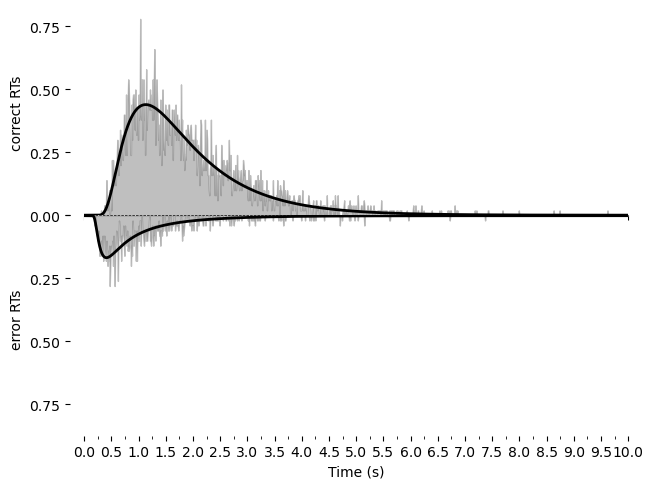

In [ ]:
# simulation setting
sim_params = {"dt": 0.001, "t": 0.1, "z": -0.5, "v": 0.9, "a": 3}
n_trials = 5000

# simulate ddm
rt, response = np.zeros(n_trials), np.zeros(n_trials, dtype=int)
for trace in range(n_trials):
    x = sim_ddm(**sim_params, seed=trace)
    rt[trace] = len(x) * sim_params["dt"]
    response[trace] = (x[-1] > 0) == (sim_params["v"] > 0)
df = pd.DataFrame({"rt": rt, "response": response})
sample = pyddm.Sample.from_pandas_dataframe(df, rt_column_name="rt", choice_column_name="response")

# drift diffusion model
ddm = pyddm.gddm(
    drift="v",
    bound="a",
    starting_position="z",
    nondecision="nd",
    parameters={"v": (-2, 2), "a": (0.1, 2), "z": (-1, 1), "nd": (0, 1)},
    T_dur=10,
    dt=sim_params["dt"],
)

# fit ddm
ddm.fit(sample, verbose=False)

# diagnostics
pprint(ddm.parameters())
pyddm.plot.plot_fit_diagnostics(model=ddm, sample=sample)

(c) Pick one rat from the data file that has a lot of trials and coherences, and fit their entire time series to a 4-parameter model (one value of `a`, `t`, and `z` shared by all trials, and a different parameter `v` for each coherence). You may need to bin the coherence values; in some experiments every coherence value was drawn uniformly on an interval, in which case each trial has a unique coherence. 

Info: Params [ 1.5626686   0.88697159 -0.16415806  0.55218299] gave 37049.75260158746


{'IC': {'x0': Fitted(-0.1641580572964516, minval=-1, maxval=1)},
 'bound': {'B': Fitted(0.8869715927293199, minval=0.4, maxval=3)},
 'drift': {'driftcoh': Fitted(1.5626685952621233, minval=-5, maxval=5)},
 'noise': {'noise': 1},
 'overlay': {'nondectime': Fitted(0.552182987940078, minval=0, maxval=1),
             'umixturecoef': 0.02}}


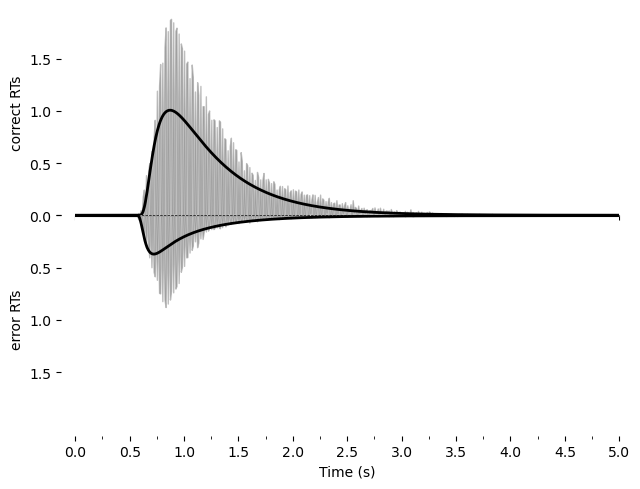

In [3]:
# load data from one rat w/ 12 coherences
cols = ["subjectID", "coh", "rt", "response"]
df = pd.read_csv("datasets/allEpochsRAT200502.csv", usecols=cols).query("subjectID == 482")
sample = pyddm.Sample.from_pandas_dataframe(df, rt_column_name="rt", choice_column_name="response")

# drift diffusion model
ddm = pyddm.gddm(
    drift=lambda coh, driftcoh: driftcoh * coh,
    noise=1,
    bound="b",
    nondecision="ndt",
    starting_position="z",
    parameters={"driftcoh": (-5, 5), "z": (-1, 1), "b": (0.4, 3), "ndt": (0, 1)},
    T_dur=5,
    conditions=["coh"],
)

# fit ddm
ddm.fit(sample=sample, verbose=False)
pprint(ddm.parameters())
pyddm.plot.plot_fit_diagnostics(model=ddm, sample=sample)

(d) For comparison, fit the entire time series to the 7-parameter model, with one value for each noise parameter `sv`, `st`, and `sz` for all trials.

In [ ]:
# !!! 3 min runtime !!!

# 6-param drift diffusion model
ddm = pyddm.gddm(
    drift=lambda coh, driftcoh: driftcoh * coh,
    noise=1,
    bound="b",
    starting_position=lambda z, sz, x: stats.uniform(z - sz / 2, sz).pdf(x),
    nondecision=lambda ndt, sndt, T: stats.uniform(ndt - sndt / 2, sndt).pdf(T),
    parameters={
        "driftcoh": (-5, 5),
        "b": (0.4, 3),
        "ndt": (0, 1),
        "sndt": (0.1, 1),
        "z": (-1, 1),
        "sz": (0.1, 1),
    },
    T_dur=5,
    conditions=["coh"],
)

# fit ddm
ddm.fit(sample=sample, verbose=False, lossfunction=pyddm.models.loss.LossRobustLikelihood)
pprint(ddm.parameters())
pyddm.plot.plot_fit_diagnostics(model=ddm, sample=sample)